In [25]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'Monospace'
plt.rcParams['figure.figsize'] = [8,6]

In [15]:
#First we define as few variables
N = 1000 #resolution
delta = 2*np.pi/N #Spacing between points

# E1
#### a) Defining a sparse matrix that is elementwise cosine

In [20]:
#Defining the phi values, this is essentially our potential
phi = np.linspace(-np.pi, np.pi, N)

cosMatrix = np.diag(np.cos(phi))

#### b) The $q^2$ matrix

In [21]:
diagArr = np.ones(N)
offDiagArr = np.ones(N-1)

q2Matrix = 1/delta**2 * (2*np.diag(diagArr) - np.diag(offDiagArr, k = 1) - np.diag(offDiagArr, k = -1))

#### c) The tunable transmon Hamiltonian
The Hamiltonian is given by equation (22) in "A Qunatum Engineer's Guide to Superconducting Qubits" and is 
$$H=4E_Cn^2-E_J\sqrt{\cos(\phi_e)^2+d^2\sin(\phi_e)}\cos(\phi)$$

In [22]:
#Defining a function that returns the Hamiltonian, which is the su of the potential and kinetic energy and the energy scale which will be used for plotting later
def hamiltonian(E_C, E_J, phi_e, d=1):
    E_kin = 4*E_C*q2Matrix
    E_pot = -E_J*np.sqrt(np.cos(phi_e)**2+d**2*np.sin(phi_e)**2)*cosMatrix
    return E_kin + E_pot, E_J*np.sqrt(np.cos(phi_e)**2+d**2*np.sin(phi_e)**2)

#### d) Computing the eigenvalues and eigen vectors

In [23]:
H, scale = hamiltonian(1, 50, phi_e=0)

#k is number of eigenvalues and eigenvectors it finds and SR it means that it finds the pairs that have the eigenvalues with the smallest real part
eigenvalues, eigenvectors = sc.sparse.linalg.eigs(H, k=7, which = "SR")  


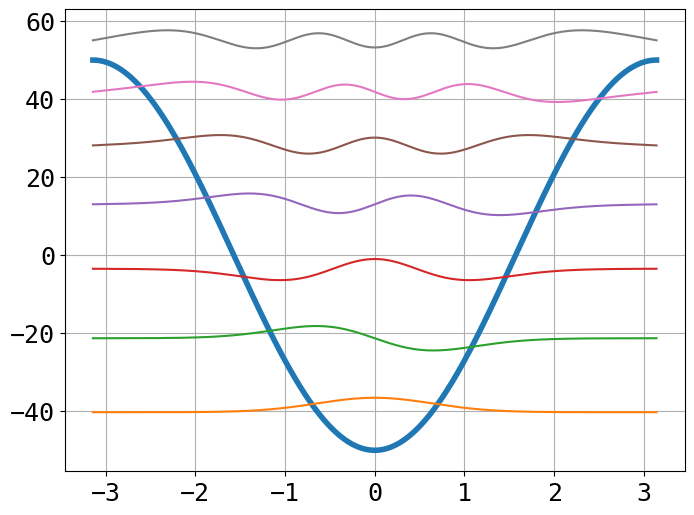

In [29]:
#We can then plot our potential and our wavefunctions

plt.plot(phi, -scale*np.cos(phi), linewidth = 4)

for i in range(7):
    plt.plot(phi, -eigenvectors[:,i]*scale + eigenvalues.real[i])